# 🧠 Extract activity from single or multi-neuron voltage imaging data
### Steps

*** Put tiff file into "video" folder, put averaged png into "background" folder ***
1) Import stuff 
2) Set parameters for recording / analysis and load recording
3) Plot mean activity in cell vs non-cell regions as an initial look
4) Mild filter and pixel-wise rolling mean / std
5) Normalise trace +/- background correction 
6) Plot heatmap of activity, and videos of some of the "high activity" episodes (only if background correction step performed) 


### 1) Imports

In [1]:
import numpy as np,os,importlib,matplotlib.cm as cm, matplotlib as mpl,  glob
import pickle as pkl, pickle as pkl, seaborn as sns
from scripts import dfFunc as dF, vFunc as vF, pltFunc as pF, analyse
sns.set_style('white')
def rel(): importlib.reload(dF),importlib.reload(vF),importlib.reload(pF),importlib.reload(analyse)

/home/alex/miniconda3/envs/voltage_4/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-29 14:05:00,984	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
<frozen importlib._bootstrap_external>:1181: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
<frozen importlib._bootstrap_external>:1181: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.


### 2) Define parameters & load video

Set background image and tif recording file names

In [10]:
BG_IMAGE = "AVG_HB_test.png"
TIF_REC = "HB_test.tif"

Set parameters of recording and analysis: eg, FPS of recording, duration of rolling window and std for filter

In [ ]:
Info = {'name': 'test',
        'fps': 100,                                                     # fps of recording
        'bgr': BG_IMAGE,      # Collect background image
        'std': 3,                                                       # Cutoff z-score
        'perc': 90,                                                     # Percentile cutoff for activity episodes
        'filt': (2, 2, 2),                                              # Gaussian filter std (time, y, x)
        'sec': 3,                                                       # duration for rolling mean/std in seconds. ~3 seconds reasonable...
        'hyp': False,                                                   # Hyperpolarisation analysis (ignore this for now)
        'gpu': True,                                                    # Use gpu? WAY faster....
        'par': False}                                                   # Use parallel processing? (GPU better)

pkl.dump(Info, open('figures/analysisInfo.pkl','wb'))

Load recording

In [14]:
FILE = os.path.join('video', TIF_REC)
fullTiff = dF.loadTiff(FILE).astype(np.float32)
Info['meanImage'] = np.mean(fullTiff, axis = 0)   
print('tiff dimensions are: {}  \ntiff name is: {}'.format(fullTiff.shape, FILE))

tiff dimensions are: (10000, 35, 41)  
tiff name is: video/HB_test.tif


### 3) Plot mean activity in "cell" and "non-cell" regions to get a rough idea of the activity during the recording  

Select a cutoff intensity for cell vs non-cell regions. To do this, plot some images with different intensity thresholds to select a cutoff value. Change the thresholds until an image that shows cell vs non-cell regions looks reasonable.  

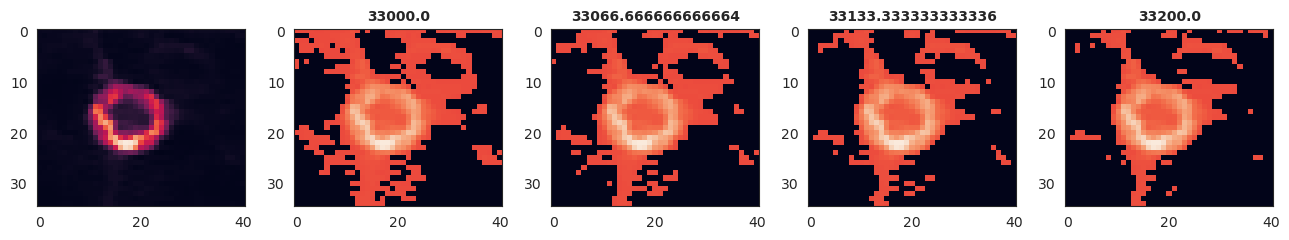

In [17]:
MIN, MAX = 33000, 33200                         # <- select upper/lower range of intensity threshold to check here

pF.medCutoff(Info['meanImage'], Info['bgr'], np.linspace(MIN, MAX, 4),\
             save={'fname':'figures/cutoffs.png','dpi':300})

Select an intensity threshold. This defines cell vs non-cell regions. This threshold can be used for background correction later (which is optional) 

In [25]:
Info['cutoff'] = 33133

Plot average fluorescence across "cell" vs "non-cell" pixels. Save the trace. 

This is just to get an idea of when activity might be happening during the recording.

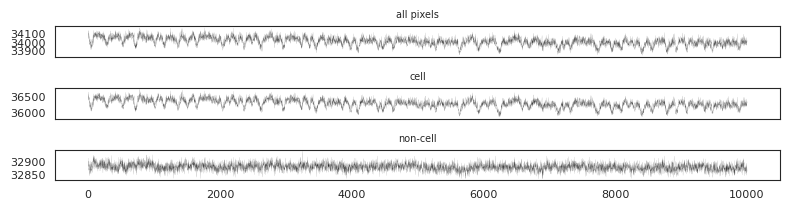

In [26]:
# Save figure as:
saveAveTr = {'fname':'figures/aveTraceNonCell' + str(Info['cutoff']) + '.png', 'dpi':400}

# Plot figure
size = (8, 2.2)
pF.plotAveTrace(fullTiff, Info['meanImage'] , cut = Info['cutoff'], save = saveAveTr, size = size)

### 4) Filter and get pixel-wise rolling mean/std of tiff recording

Apply mild Gaussian filter (defined earlier under "info" dictionary). Get pixel-wise temporal rolling mean and std of recording.

In [19]:
fData = analyse.filterTiff(fullTiff, Info) 

Getting rolling mean/std of movie... 

Plot the mean/std of the raw trace, and plot the normalised trace, for 10 pixels with the highest mean intensity. Cut-off Z-score (red dotted lines) defined earlier under "info".

This is just a sanity check to make sure the filtering worked properly!

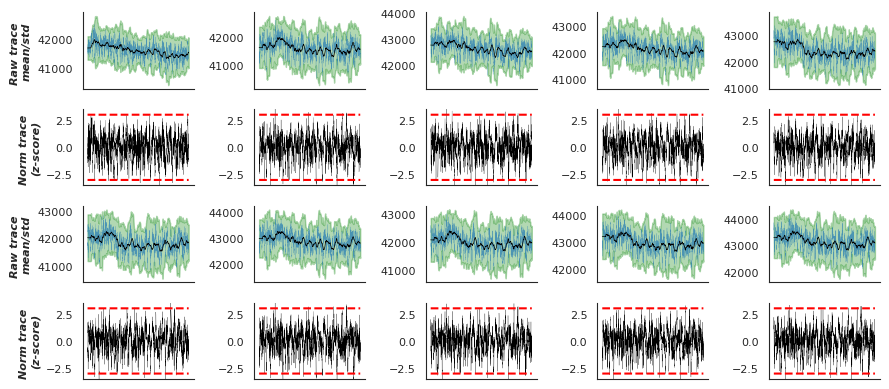

In [27]:
rel()
size = (9, 4)                   # Change size of plot here
pF.plotPixResults(fData, Info, save='figures/normPlot_' + str(Info['sec']) + '.png', size = size)

Save the filtered data?

In [ ]:
#pkl.dump(fData, open('data/fData_std_' + str(Info['std']) + 'filt_' + str(Info['filt']) + Info['name'] + '.pkl', 'wb'))

### 5) Normalise recording, +/- perform background correction by extracting all "blobs" of activity and their summed intensity

1. Normalise and threshold the recording (values < threshold = 0)
    * Make sure you're happy with the Z-score cutoff above
2. Optional -> perform background correction:
    * Get continuous activity episodes above threshold 
    * Remove activity with summed intensity < certain %ile of background

Returns a dictionary containing:
1. Normalised + thresholded recording (needed to find hotspots)
2. Labelled data (dict): 
    * "labArray": recording with label number of each significant blobs
    * "nabels": number of significant blobs
    * "aucs": summed intensity of each significant blob}
3. Labelled data (as above) but just for non-cell regions (?? remove this)
4. Pixel indices corresponding to cell locations (needed to find hotspots)

In [29]:
# NOTE: 18000 episodes takes ~2 minutes using GPU
Info['gpu'] = True                  # Use GPU?
correctBackground = True            # Do bg correction?

cntData = analyse.getActivity(fData, Info, bgCorrect = correctBackground)

getting continuous activity episodes... | getting Aucs...
using GPU...
998  total activity episodes...  getting continuous activity episodes... | getting Aucs...
using GPU...
1037  total activity episodes...  removing activity episodes below cutoff in cell-only and non-masked movies...
998 and 1037 continuous episodes in total and non-cell regions            


Save the data: use to run "getHotspots.ipynb" to identify significant hotspots.

The hotspots notebook only needs 1) Thresholded recordings, and 2) pixel indices corresponding to cell locations

In [30]:
pkl.dump(cntData,open('data/cntData_' + Info['name'] + '.pkl','wb'))

### 6) Plot a heatmap of all "blobs" of activity

***Only do this step if background correction performed, and all spatio-temporal "blobs" of activity have been extracted***

Create heatmap(s) by summing thresholded activity across the recording. Plot is based on either all the activity or just the continuous "blobs" selected in step 5. Can also set the z-score cutoff for plotting.  

In [ ]:
hmInfo = {
        'stdHm': Info['std'],        # Z-score threshold for plotting. Default is info['std']
        'AlphHm':0.3,                # Alpha blend for background image: lower = more see-through 
        'CmHm': {'depol':cm.jet,     # Cmap for depolarisation. Jet is classic.
                 'hyp':cm.jet},      # Cmap for hyperpolarisation (NOT USED CURRENTLY). 
        'ThHm': np.linspace(0,1,11), # Plot 11 heatmaps with a different display threshold - this selects for more active regions.
        'upSampHm': 5,               # Upsample image for display  
        'inlineHm': False,           # Plot heatmaps inline also? 
        'filtHm': (2,2),             # Filter activity for display  
        'plotHm':{'All':True,        # Which heatmaps to plot? All or continuous epochs only, or both?? 
                  'Epochs':True}
        }
# Update Info dictionary
for KEY, val in hmInfo.items(): Info[KEY] = val

vF.dehypHmap(fData, cntData, Info)

### 7) Create videos of most intense activity episodes, +/- video of entire recording with activity overlaid

Get N most active "blobs" of activity

In [ ]:
# Plot all activity episodes and specifically non-cell activity episodes
#pF.plotActDist(cntData, Info, Save = 'figures/actDist_' + \
#               str(Info['std']) + 'filt_' + str(Info['filt']) + '.png')

# Plot and get high activity episodes
N = 20
hActFrames = pF.plotHighAct(cntData, N = N)

Get videos of high activity episodes (need ffmpeg installed). Set the speed of the videos, duration, etc  

In [ ]:
vInfo = {'hSpeed':0.1,                          # Speed of video (0.1x - 0.3x best)
         'hPad':0.1,                            # Pad video on either side of activity (seconds - ~0.1 looks ok)
         'vAlph': 0.5,                          # Alpha value for movie
'vAbase':0.1,                                   # Set threshold for activity to display: higher = only more intense activity shown
         'hRange':[Info['std'], Info['std']+1], # Lower and upper range for cMap (change for diverging depol + hyper)       
         'highAct':hActFrames,                  # depolarising high activity frames
         'vFilt':(2,2)                          # Gaussian filter for each activity frame
        }

for KEY,val in vInfo.items():Info[KEY]=val

vF.slowVids(fData, cntData, Info)


Create full video of activity

In [ ]:
# *** full video ***
rel()

fvInfo = {'fvSpeed':0.5,                  # Speed of video
         'vAlph': 0.5,                  # Alpha value for movie
         'hRange':[Info['std'], 3.0],   # Lower and upper range for cMap (change for diverging depol + hyper)     
         'vFilt':(1,1),                  # Gaussian filter for each activity frame
         'fvRange':[0,40000],                   # Frame range of movie
         'fvName': 'activityMaps/depol_fullMov_'+\
                Info['name']+str(Info['std'])+\
                "_"+''.join([str(F) for F in Info['filt']])+"_"+str(Info['perc'])+\
                "perc_"
}

for KEY,val in fvInfo.items():
       Info[KEY] = val

# Get colormap
cNorm = mpl.colors.Normalize(vmin = Info['hRange'][0], vmax = Info['hRange'][1])    # Dynamic range
cMap = cm.ScalarMappable(norm = cNorm, cmap = Info['CmHm']['depol'])                # Colormap

vF.pngVidConvert(cntData['threshTiff'], Info, cMap, fps = Info['fvSpeed'] * Info['fps'],\
                 fName = Info['fvName'] + str(Info['fvSpeed']) + "speed_2_STD2.mp4", Range = Info['fvRange'])
